In [53]:
import pandas as pd
import matplotlib.pyplot as plt

### **Một vài function...**

In [9]:
def get_date(datetime: str):
    return datetime.split()[0]

def get_time(datetime: str):
    return datetime.split()[1]

### **Chuyển đổi dữ liệu**

Dữ liệu giao dịch theo *từng phút* chuyển sang *từng ngày*

In [100]:
def day_by_day(df: pd.DataFrame):
    COLS_NAME = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

    interval = df['Date'].drop_duplicates().to_list()

    new_df = []

    for date in interval:        
        rows = df[(df['Date'] == date)]
        
        max_high = rows['High'].max()
        min_low = rows['Low'].min()

        first_open = rows.iat[0,1]
        last_close = rows.iat[len(rows)-1,4]

        sum_volume = rows['Volume'].sum()

        new_df.append([date, first_open, max_high, min_low, last_close, sum_volume])

    return pd.DataFrame(new_df, columns=COLS_NAME)
    

### **Load PNJ data**

In [25]:
data = pd.read_csv('PNJ.csv')

### **Tách Date/Time trở thành Date và Time,**
### **Loại bỏ những cột không cần thiết: Ticker, Date/Time và Open Interest**

In [97]:
data['Date'] = data['Date/Time'].apply(get_date)
data['Time'] = data['Date/Time'].apply(get_time)

data = data.drop(['Open Interest', 'Date/Time'], axis=1)

### **Lấy dữ liệu theo ngày**

In [98]:
data_dbd = day_by_day(data)

### **Dữ liệu sau khi được chuyển đổi**

In [99]:
print(data_dbd)

           Date   Open   High    Low  Close   Volume
0     2/28/2018  78.14  80.61  78.09  78.71     8158
1      3/1/2018  78.14  80.32  77.66  77.66    20511
2      3/2/2018  77.14  77.90  76.86  77.33    37274
3      3/5/2018  77.14  80.50  77.14  78.28    27737
4      3/6/2018  78.61  83.13  77.43  81.45    41077
..          ...    ...    ...    ...    ...      ...
704  12/16/2020  77.20  77.60  77.00  77.60   636190
705  12/17/2020  76.50  77.40  75.00  75.80  1289500
706  12/18/2020  75.80  77.50  75.80  77.30   582740
707  12/21/2020  77.30  77.40  76.50  77.30   676290
708  12/22/2020  77.70  78.70  77.00  78.30   957080

[709 rows x 6 columns]


### **Nhận xét**
*Dữ liệu được nén từ xấp xỉ 100,000 xuống còn 709 dòng.*

*Từ kết quả trên, có thể nhận thấy dữ liệu được ghi nhận từ 28/02/2018 đến 22/12/2020.*

### test

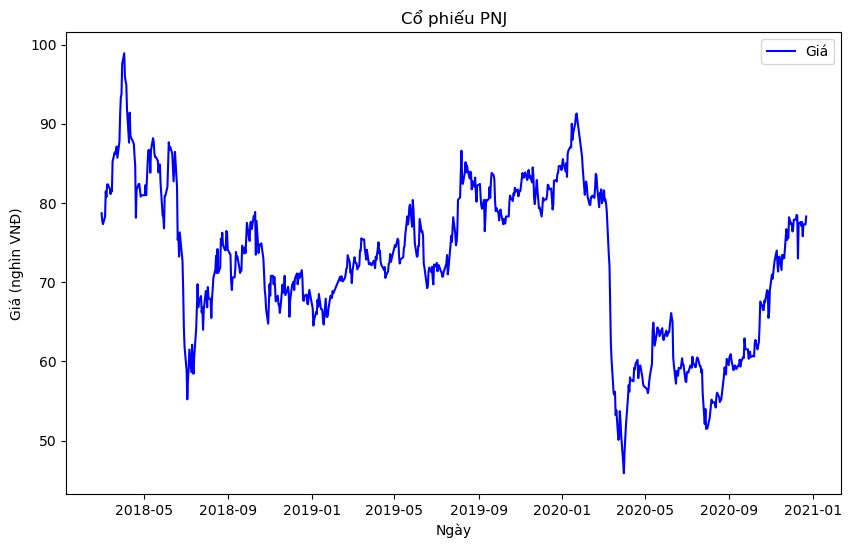

In [106]:
df = data_dbd.copy()

df['Date'] = pd.to_datetime(df['Date'])

# Plotting 'Close' values
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Close'], label='Giá', color='blue')
plt.title('Cổ phiếu PNJ')
plt.xlabel('Ngày')
plt.ylabel('Giá (nghìn VNĐ)')
plt.legend()
plt.show()

In [104]:
no_date = df.drop(['Date'], axis=1)
corr = no_date.corr()

print(corr)

            Open      High       Low     Close    Volume
Open    1.000000  0.992990  0.993992  0.986643 -0.212151
High    0.992990  1.000000  0.992219  0.992959 -0.205463
Low     0.993992  0.992219  1.000000  0.993224 -0.225731
Close   0.986643  0.992959  0.993224  1.000000 -0.203914
Volume -0.212151 -0.205463 -0.225731 -0.203914  1.000000


In [107]:
df.to_csv('PNJ-test.csv', index=False)